In [1]:
%load_ext autoreload
%autoreload 2
from toolbox import QueryConstructor, ConstituteAdjustment
from ntiles import Ntile
from toolbox.db.testing.portal import PricingPortal

In [5]:
tbl = 'crsp.security_daily'
uni = 'CRSP_US_1000'
start = '2000'
end = '2021-11'
search_by = 'permno'

In [6]:
ca = ConstituteAdjustment(search_by, 'period')
ca.add_index_info_from_db(uni, start, end)

In [7]:
portal = PricingPortal(schema='crsp', assets=uni, search_by=search_by, start=start, end=end)
tile = Ntile(portal)

In [8]:
qc_pricing = QueryConstructor().query_timeseries_table('crsp.security_daily', ['prc'], uni,
                                        search_by='permno', start_date=start, end_date=end).distinct().set_calendar('NYSE')

qc_temp_factor = QueryConstructor().query_timeseries_table('wrds.firm_ratios', ['PEG_1yrforward', 'bm', 'ps'], uni,
                                        search_by='permno', start_date=start, end_date=end)\
    .distinct().resample('NYSE', 35).join(qc_pricing, tbl_name='pricing_tbl', on={'permno':'permno', 'date':'date'})

temp_factor = qc_temp_factor.df

In [19]:
factor = temp_factor.unstack().shift(1).stack()
alpha = ca.adjust_data_for_membership(factor['peg_1yrforward'], 'factor')

Quantiles Statistics


,Median,Std,Min,Max,Count,Count %
Ntile:,,,,,,
1,4.22,6.53,1.04,65.06,925966,20.01
2,1.58,0.69,-0.12,4.95,923945,19.97
3,0.80,0.46,-1.27,2.31,924239,19.98
4,0.03,0.45,-3.49,1.12,924771,19.99
5,-2.43,11.05,-170.26,0.25,927808,20.05


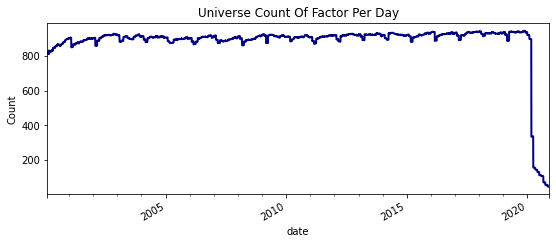

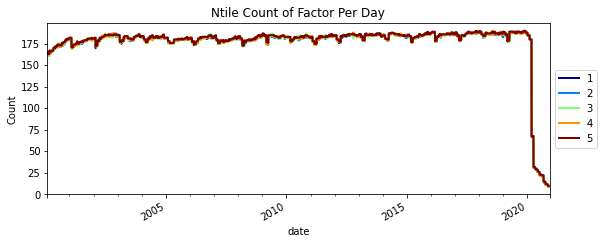

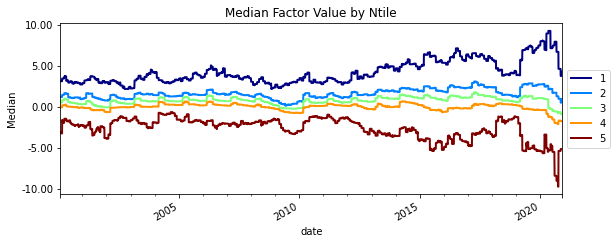

Ntile Backtest


,Sharpe,CAGR,Annual Vol,Max Drawdown,% Periods Up
Ntile: 1,-0.06,-0.44,5.19,-30.83,0.49
Ntile: 2,0.52,2.65,5.27,-11.33,0.52
Ntile: 3,0.52,2.76,5.52,nan,0.51
Ntile: 4,-0.28,-2.55,8.07,-23.77,0.50
Ntile: 5,-0.32,-2.03,5.85,-17.33,0.50


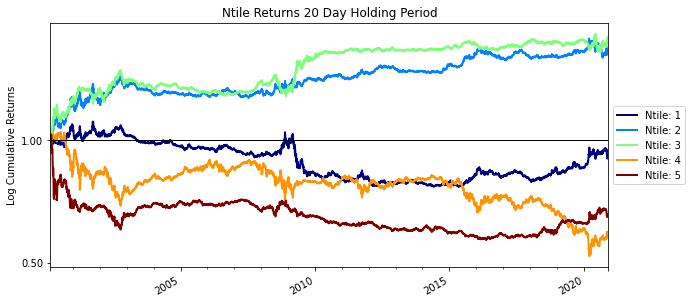

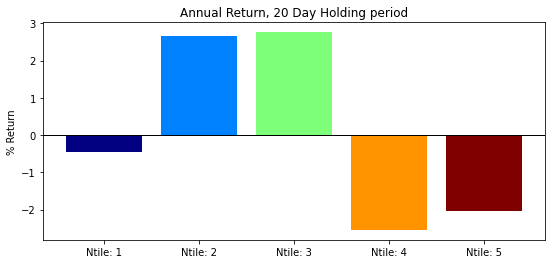

,Sharpe,CAGR,Annual Vol,Max Drawdown,% Periods Up
universe,0.30,4.37,22.57,-60.90,0.53
1 vs 5,0.19,0.70,4.06,-17.63,0.51
2 vs 4,0.40,2.34,6.24,-17.68,0.51


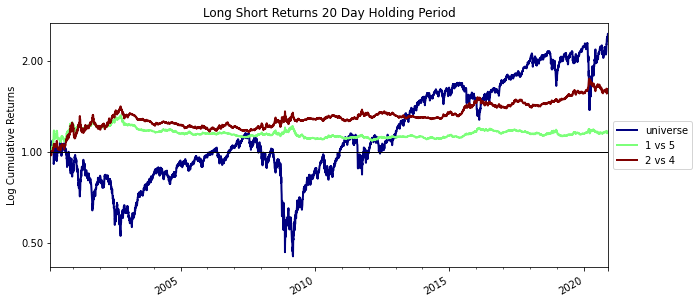

Information Coefficient


,IC Mean,IC Median,IC Std,Risk Adjusted IC,IC Skew
20D,0.002,0.002,0.045,0.05,-0.033


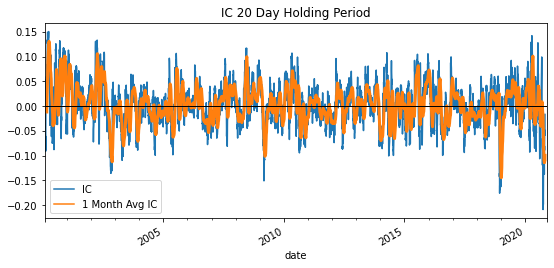

Turnover


,Mean AC,Median AC,Std AC
20D,0.717,0.795,0.203


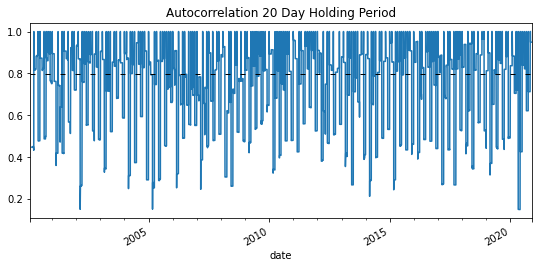

In [20]:
t = tile.full_tear(alpha, holding_period=20, ntiles=5, show_uni=True, market_neutral=True)
del t
